In [12]:
token = "dddc5ba0186a6283e58e11bf20c8b76bffc00e994597e332f19a71cf53393ffc3653034ddc222560ce1e8498e274e980954d2a2e7c8fb5ae4242a7d7f966dcd3"

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
    overwrite=True
)

In [13]:
# Load saved credentials
service = QiskitRuntimeService()

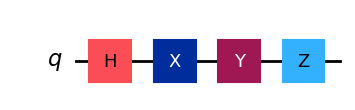

In [14]:
from qiskit import QuantumCircuit

# Create a single-qubit quantum circuit
qc = QuantumCircuit(1)

# Apply basic gates
qc.h(0)  # Hadamard gate (creates superposition)
qc.x(0)  # Pauli-X (NOT gate)
qc.y(0)  # Pauli-Y
qc.z(0)  # Pauli-Z (phase flip)

# Visualize the circuit
qc.draw("mpl")


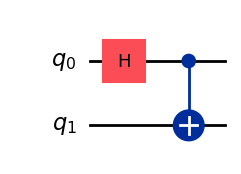

In [15]:
# Create a 2-qubit quantum circuit
qc = QuantumCircuit(2)

# Apply Hadamard to qubit 0
qc.h(0)

# Apply CNOT gate (entangles qubits)
qc.cx(0, 1)

# Visualize the circuit
qc.draw("mpl")


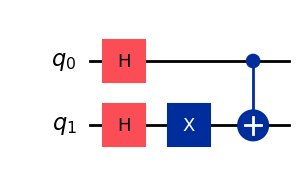

In [7]:
# Create a 2-qubit circuit with a combination of gates
qc = QuantumCircuit(2)

qc.h(0)      # Superposition on qubit 0
qc.h(1)      # Superposition on qubit 1
qc.x(1)      # Apply Pauli-X to qubit 1
qc.cx(0, 1)  # Entangle the qubits with a CNOT

# Visualize the circuit
qc.draw("mpl")


Using backend: ibm_kyiv


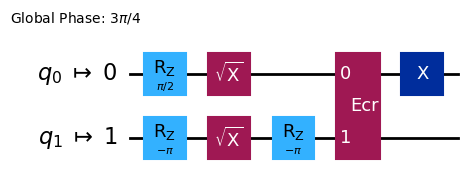

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Connect to IBM Quantum Service
service = QiskitRuntimeService()

# Select the least busy real quantum device
backend = service.least_busy(simulator=False, operational=True)
print(f"Using backend: {backend.name}")  # Print selected backend

# Convert to an ISA circuit (optimized for execution)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

# Visualize the optimized circuit
isa_circuit.draw("mpl", idle_wires=False)


Using backend: ibm_sherbrooke
Generated Operators: ['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIII

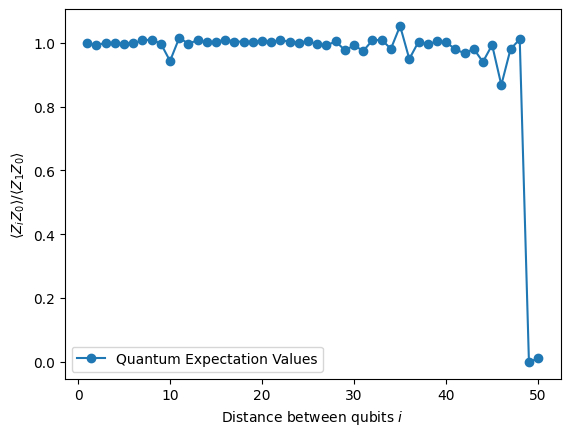

In [12]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorOptions, EstimatorV2
from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt

# ✅ Step 1: Connect to IBM Quantum Service
service = QiskitRuntimeService()

# ✅ Step 2: Select the least busy quantum backend
backend = service.least_busy(simulator=False, operational=True)
print(f"Using backend: {backend.name}")  # Print the selected backend

# ✅ Step 3: Create a quantum circuit
qc = QuantumCircuit(51)  # Use more qubits to generate multiple data points
qc.h(0)
qc.cx(0, 1)

# ✅ Step 4: Convert the circuit for execution (ISA optimized)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(qc)

# ✅ Step 5: Define multiple observables for expectation values
n = qc.num_qubits  # Get number of qubits from the circuit

operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (n - 2 - i) for i in range(n - 1)
]  # Creates multiple measurement operators

print("Generated Operators:", operator_strings)  # Debugging
print("Total Operators:", len(operator_strings))  # Should match data points

# ✅ Convert to Qiskit observables
operators = [SparsePauliOp(operator) for operator in operator_strings]

# ✅ Apply layout mapping to observables
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

# ✅ Step 6: Set up execution options
options = EstimatorOptions()
options.resilience_level = 1  # Noise mitigation
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

# ✅ Step 7: Create an Estimator with options
estimator = EstimatorV2(backend, options=options)

# ✅ Step 8: Submit the job with multiple observables
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(f"Job ID: {job_id}")

# ✅ Step 9: Retrieve the results
result = job.result()[0]  # Extract first result
values = result.data.evs  # Expectation values

# ✅ Step 10: Normalize the expectation values for analysis
values = [v / values[0] for v in values]

# ✅ Step 11: Plot the results with multiple data points
data = list(range(1, len(operators) + 1))  # Distance between operators
plt.plot(data, values, marker="o", label="Quantum Expectation Values")
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()
